In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,MaxPooling1D,BatchNormalization,Flatten,Dense
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Utility

In [2]:
def feature_split(df=None,col=None):
  """
  df : dataframe
  col : column of dataframe
  feature_dic: unique element and their count
  feature_label: unique element and their label
  """
  feature_list = [i.split('|') for i in df[col]]
  feature_dic = {}
  feature_label = {}
  cnt = 0
  for string in feature_list :
    for element in string:
      if element not in feature_dic.keys():
        feature_dic[element] = 1
        feature_label[element] = cnt
        cnt += 1
      else:
        feature_dic[element] += 1
  return feature_dic, feature_label

# For test only
#feature_dic, feature_label = feature_split(df,'target')

In [3]:
def feature_one_hot_encoding(df=None,col=None):
  """
  df : dataframe
  col : column of dataframe
  """
  feature_dic, _ = feature_split(df,col)
  feature_list = np.asarray([i.split('|') for i in df[col]],dtype=object)
  feature_binary = []
  for i in feature_list:
    tmp = []
    for j in  feature_dic.keys():
      if j in i:
        tmp.append(1)
      else:
        tmp.append(0)
    feature_binary.append(tmp)
  return np.asarray(feature_binary)


# For test only
#feature_binary = feature_one_hot_encoding(df,'target')
#print(f'one hot encoding length: {len(feature_binary)}')
#print(f'one hot encoding length: {len(feature_binary[0])}')

In [4]:
def Jaccard_similarity(l1=None,l2=None):
  """
  l1: a list of binary
  l2: a list of binary
  """
  l1 = np.asarray(l1)
  l2 = np.asarray(l2)
  numerator = np.sum(np.bitwise_and(l1,l2))
  denominator = np.sum(np.bitwise_or(l1,l2))
  return numerator / denominator

# For test only
#feature_binary = [[1,1,0,1],[0,1,0,1],[0,0,0,1]]
#similarity = Jaccard_similarity(feature_binary[0],feature_binary[1])
#similarity

In [5]:
def similarity_matrix(l1=None):
  """
  l1: a list of binary
  """
  l1 = np.asarray(l1)
  matrix = []
  for i in l1:
    tmp = []
    for j in l1:
      x = Jaccard_similarity(i,j)
      tmp.append(x)
    matrix.append(tmp)
  return np.asarray(matrix)

In [6]:
def similarity_matrix_stack(df=None, feature=None):
  """
  feature: A list of feautre names
  """
  for i, col in enumerate(feature):
    feature_binary = feature_one_hot_encoding(df,col)
    matrix = similarity_matrix(feature_binary)
    if i == 0:
      matrix_stack = np.expand_dims(matrix, axis=0)
    else:
      matrix = np.expand_dims(matrix, axis=0)
      matrix_stack = np.concatenate((matrix_stack,matrix),axis=0)
  return matrix_stack


## For test only
#matrix_stack = similarity_matrix_stack(df,feature=['target','enzyme','pathway','smile'])
#matrix_stack.shape

In [7]:
# Not used, for backup only.
def label_encoding(l1=None):
  """
  l1: A list of label
  """
  le = preprocessing.LabelEncoder()
  le.fit(l1)
  le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
  return le_name_mapping

# Data Preprocessing

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df = pd.read_csv("/content/drive/MyDrive/mediAI/DDI-CNN/data/data_new.csv")
print(f'Size of data frame: {df.shape}')
print(f'Number of unique drugs: {len(df.drug_name.unique())}')
df.head()

Size of data frame: (3475, 7)
Number of unique drugs: 3475


,smiles,drug_name,DrugBank ID,Targets,SNP Effects,Drug Interactions,Enzymes
0,3,Aluminium,DB01370,"['Serotransferrin', 'Sodium/potassium-transpor...",[unknown],"['DB06210', 'DB00451', 'DB09020', 'DB01112', '...",[unknown]
1,10,Chromium,DB11136,['Cytochrome b5'],[unknown],"['DB00091', 'DB00159', 'DB00229', 'DB00244', '...",[unknown]
2,183,Platinum,DB12257,[unknown],[unknown],"['DB01030', 'DB00252', 'DB01320', 'DB01229', '...",[unknown]
3,260,Zinc,DB01593,"['B1 bradykinin receptor', 'Methylated-DNA--pr...","['Pterine Biosynthesis', 'beta-Alanine Metabol...","['DB06210', 'DB06817', 'DB01415', 'DB00567', '...",['Carbonic anhydrase 1']
4,303,Calcium,DB01373,['Voltage-dependent L-type calcium channel sub...,['Alpha Linolenic Acid and Linoleic Acid Metab...,"['DB00218', 'DB00365', 'DB00467', 'DB00487', '...",[unknown]


In [10]:
# Label encoding
encode_name = {}
for i, drug in enumerate(df['drug_name']):
  encode_name[drug] = i

df['name_label'] = df['drug_name'].map(encode_name)
df.head()

,smiles,drug_name,DrugBank ID,Targets,SNP Effects,Drug Interactions,Enzymes,name_label
0,3,Aluminium,DB01370,"['Serotransferrin', 'Sodium/potassium-transpor...",[unknown],"['DB06210', 'DB00451', 'DB09020', 'DB01112', '...",[unknown],0
1,10,Chromium,DB11136,['Cytochrome b5'],[unknown],"['DB00091', 'DB00159', 'DB00229', 'DB00244', '...",[unknown],1
2,183,Platinum,DB12257,[unknown],[unknown],"['DB01030', 'DB00252', 'DB01320', 'DB01229', '...",[unknown],2
3,260,Zinc,DB01593,"['B1 bradykinin receptor', 'Methylated-DNA--pr...","['Pterine Biosynthesis', 'beta-Alanine Metabol...","['DB06210', 'DB06817', 'DB01415', 'DB00567', '...",['Carbonic anhydrase 1'],3
4,303,Calcium,DB01373,['Voltage-dependent L-type calcium channel sub...,['Alpha Linolenic Acid and Linoleic Acid Metab...,"['DB00218', 'DB00365', 'DB00467', 'DB00487', '...",[unknown],4


In [11]:
df2 = pd.read_csv("/content/drive/MyDrive/mediAI/DDI-CNN/data/data_mechanism.csv")
df2

,mechanism,action,drugA,drugB
0,the anticoagulant activities activities of,increase,Apixaban,Lepirudin
1,The risk risk or severity of,increase,Dasatinib,Lepirudin
2,The risk risk or severity of,increase,Lepirudin,Deferasirox
3,The risk risk or severity of,increase,Edoxaban,Lepirudin
4,The risk risk or severity of,increase,Ibrutinib,Lepirudin
...,...,...,...,...
132943,The risk risk or severity of,increase,Gedivumab,Amivantamab
132944,The risk risk or severity of,increase,Istiratumab,Amivantamab
132945,The risk risk or severity of,increase,Pidilizumab,Amivantamab
132946,The risk risk or severity of,increase,GMA-161,Amivantamab


In [12]:
# Create label
df2['label'] = df2['mechanism'] + " " + df2['action']
df2

,mechanism,action,drugA,drugB,label
0,the anticoagulant activities activities of,increase,Apixaban,Lepirudin,the anticoagulant activities activities of inc...
1,The risk risk or severity of,increase,Dasatinib,Lepirudin,The risk risk or severity of increase
2,The risk risk or severity of,increase,Lepirudin,Deferasirox,The risk risk or severity of increase
3,The risk risk or severity of,increase,Edoxaban,Lepirudin,The risk risk or severity of increase
4,The risk risk or severity of,increase,Ibrutinib,Lepirudin,The risk risk or severity of increase
...,...,...,...,...,...
132943,The risk risk or severity of,increase,Gedivumab,Amivantamab,The risk risk or severity of increase
132944,The risk risk or severity of,increase,Istiratumab,Amivantamab,The risk risk or severity of increase
132945,The risk risk or severity of,increase,Pidilizumab,Amivantamab,The risk risk or severity of increase
132946,The risk risk or severity of,increase,GMA-161,Amivantamab,The risk risk or severity of increase


In [13]:
df2['drugA_encoding'] = df2['drugA'] .map(encode_name)
df2['drugB_encoding'] = df2['drugB'] .map(encode_name)
df2.head()

,mechanism,action,drugA,drugB,label,drugA_encoding,drugB_encoding
0,the anticoagulant activities activities of,increase,Apixaban,Lepirudin,the anticoagulant activities activities of inc...,1819,3068
1,The risk risk or severity of,increase,Dasatinib,Lepirudin,The risk risk or severity of increase,1502,3068
2,The risk risk or severity of,increase,Lepirudin,Deferasirox,The risk risk or severity of increase,3068,649
3,The risk risk or severity of,increase,Edoxaban,Lepirudin,The risk risk or severity of increase,1355,3068
4,The risk risk or severity of,increase,Ibrutinib,Lepirudin,The risk risk or severity of increase,1119,3068


In [14]:
# Similarity matrix
matrix_stack = similarity_matrix_stack(df,feature=['smiles'])
print("Similarity matrix:",matrix_stack.shape)

Similarity matrix: (1, 3475, 3475)


In [15]:
matrix_stack

array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]]])

In [20]:
a = df2['label'].unique()
a

array(['the anticoagulant activities activities of increase',
       'The risk risk or severity of increase',
       'The therapeutic efficacy efficacy of increase',
       'the anticoagulant activities activities of decrease',
       'The therapeutic efficacy efficacy of decrease',
       'the antiplatelet activities activities of increase',
       'the thrombogenic activities activities of increase',
       'the immunosuppressive activities activities of increase',
       'the neutropenic activities activities of increase',
       'The metabolism metabolism of increase',
       'The serum concentration concentration of decrease',
       'The serum concentration concentration of increase',
       'the gastrointestinal motility motility reducing increase',
       'The risk risk or severity of and hypotension increase',
       'the hypotensive activities activities of increase',
       'The metabolism metabolism of decrease',
       'The risk risk of increase',
       'the orthostatic h

In [16]:
# Combine drugA and drugB as the input vector
X = []
for i , j in enumerate(df2['label']):
  drugA = int(df2['drugA_encoding'][i])
  drugB = df2['drugB_encoding'][i]
  drugA_vector = matrix_stack[:,drugA,:] # shape (1,3475)
  drugB_vector = matrix_stack[:,drugB,:] # shape (1,3475)
  drugAB_vector = np.vstack((drugA_vector,drugB_vector))  # shape (2,3475)
  X.append(drugAB_vector)
X=np.asarray(X)
print(X.shape)

# Reshape (for Conv1D )
X = X.transpose(0,2,1)

# One hot encoding
enc = preprocessing.OneHotEncoder()
enc.fit_transform(df2[['label']])
y = enc.transform(df2[['label']]).toarray()

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
print('Total X:{} \t Y:{} :'.format(X.shape,y.shape))
print('X_train:{} \t y_train:{}'.format(X_train.shape,y_train.shape))
print('X_valid:{} \t y_valid:{}'.format(X_val.shape,y_val.shape))
print('X_test:{} \t y_test:{}'.format(X_test.shape,y_test.shape))

(132948, 2, 3475)
Total X:(132948, 3475, 2) 	 Y:(132948, 50) :
X_train:(59680, 3475, 2) 	 y_train:(59680, 50)
X_valid:(29395, 3475, 2) 	 y_valid:(29395, 50)
X_test:(43873, 3475, 2) 	 y_test:(43873, 50)


# Model Training

In [ ]:
# Define input and output shape
input_shape = X_train.shape[1:]
num_class = y_train.shape[1]

In [ ]:
# CNN
def create_model():
  model = tf.keras.Sequential()
  model.add(Conv1D(64, 3, activation="relu", input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Conv1D(128, 3, activation="relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(512, activation="relu"))
  model.add(Dense(256, activation="relu"))
  model.add(Dense(num_class, activation = 'softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
  return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3473, 64)          448       
                                                                 
 batch_normalization (BatchN  (None, 3473, 64)         256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 3471, 128)         24704     
                                                                 
 batch_normalization_1 (Batc  (None, 3471, 128)        512       
 hNormalization)                                                 
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1735, 128)        0         
 )                                                               
                                                        

In [ ]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_val, y_val))

Epoch 1/10
1865/1865 [==============================] - 1124s 602ms/step - loss: 2.8280 - accuracy: 0.7464 - val_loss: 1.1070 - val_accuracy: 0.7536
Epoch 2/10
1865/1865 [==============================] - 1133s 607ms/step - loss: 1.1885 - accuracy: 0.7312 - val_loss: 1.2533 - val_accuracy: 0.7149
Epoch 3/10
1865/1865 [==============================] - 1111s 596ms/step - loss: 1.2455 - accuracy: 0.7160 - val_loss: 1.2529 - val_accuracy: 0.7144
Epoch 4/10
1865/1865 [==============================] - 1104s 592ms/step - loss: 1.2554 - accuracy: 0.7151 - val_loss: 1.2539 - val_accuracy: 0.7144
Epoch 5/10
1865/1865 [==============================] - 1102s 591ms/step - loss: 1.2479 - accuracy: 0.7153 - val_loss: 1.2541 - val_accuracy: 0.7144
Epoch 6/10
1865/1865 [==============================] - 1110s 595ms/step - loss: 1.2482 - accuracy: 0.7153 - val_loss: 1.2536 - val_accuracy: 0.7144
Epoch 7/10
1865/1865 [==============================] - 1074s 576ms/step - loss: 1.2480 - accuracy: 0.7153

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


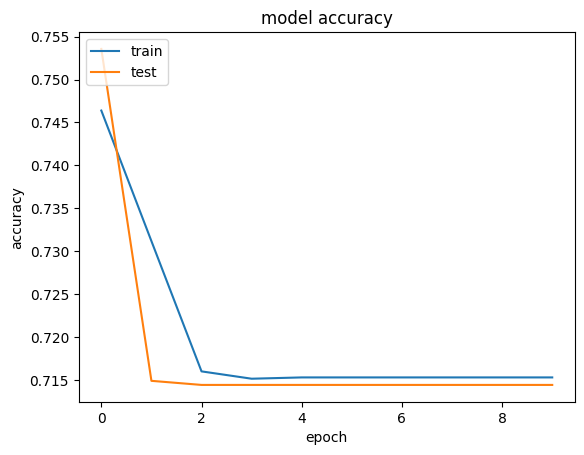

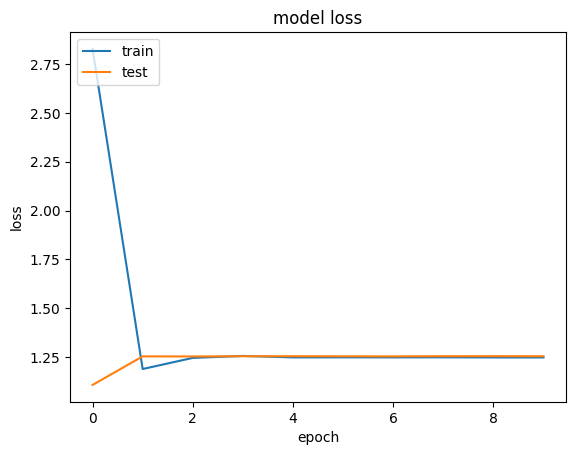

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

1372/1372 - 52s - loss: 1.2552 - accuracy: 0.7153 - 52s/epoch - 38ms/step


In [ ]:
# Prediction
pred = model.predict(X_test)
prediction = [np.argmax(i) for i in pred]
encode_label = dict([(i,j) for (i , j) in enumerate(enc.categories_[0])])
pred_decode = [encode_label[i] for i in prediction]
print(prediction[:10])
print(pred_decode[:10])

1372/1372 [==============================] - 54s 39ms/step
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
['The risk risk or severity of increase', 'The risk risk or severity of increase', 'The risk risk or severity of increase', 'The risk risk or severity of increase', 'The risk risk or severity of increase', 'The risk risk or severity of increase', 'The risk risk or severity of increase', 'The risk risk or severity of increase', 'The risk risk or severity of increase', 'The risk risk or severity of increase']


# K-Fold

In [ ]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

for train, test in kfold.split(X_train,y_train):
    # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  model = create_model()
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  #checkpoint = tf.keras.callbacks.ModelCheckpoint('./', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  history = model.fit(X_train[train],y_train[train],epochs=10,validation_data=(X_train[test],y_train[test]), callbacks=[callback])

  # Generate generalization metrics
  scores = model.evaluate(X_test,y_test, verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1492/1492 [==============================] - 736s 492ms/step - loss: 3.7556 - accuracy: 0.7318 - val_loss: 0.9208 - val_accuracy: 0.7581
Epoch 2/10
1492/1492 [==============================] - 739s 496ms/step - loss: 0.8743 - accuracy: 0.7571 - val_loss: 0.9425 - val_accuracy: 0.7785
Epoch 3/10
1492/1492 [==============================] - 754s 505ms/step - loss: 0.8708 - accuracy: 0.7679 - val_loss: 0.9639 - val_accuracy: 0.7445
Epoch 4/10
1492/1492 [==============================] - 736s 493ms/step - loss: 0.9105 - accuracy: 0.7525 - val_loss: 0.9173 - val_accuracy: 0.7477
Epoch 5/10
1492/1492 [==============================] - 749s 502ms/step - loss: 0.8938 - accuracy: 0.7535 - val_loss: 0.9143 - val_accuracy: 0.7477
Epoch 6/10
1492/1492 [==============================] - 733s 491ms/step - loss: 0.9020 - accuracy: 0.7534 - val_loss: 0.9064 - val_accuracy: 0.7478
Score for fold 

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')